In [66]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,TensorDataset
from cnn_model import Model
from sklearn.metrics import roc_auc_score
import datetime
import matplotlib.pyplot as plt

In [67]:
# 数据载入与处理
fea_col=np.load("data/fea_col.npy",allow_pickle=True)
train=pd.read_csv('data/train_set.csv')
test=pd.read_csv('data/val_set.csv')
train=(train.drop(columns='Label').values,train['Label'].values)
test=(test.drop(columns='Label').values,test['Label'].values)
train_set=TensorDataset(torch.tensor(train[0]).float(),torch.tensor(train[1]).float())
test_set=TensorDataset(torch.tensor(test[0]).float(),torch.tensor(test[1]).float())

In [68]:
# 超参数
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
batch_size=256
epochs=20
lr_rate=0.01
label_leaking_rate=0.1

In [69]:
# dataloader
trainloader=DataLoader(train_set,batch_size=batch_size,shuffle=True)
testloader =DataLoader(test_set ,batch_size=batch_size,shuffle=True)
# Model loader
M=Model(fea_col,gpu=torch.cuda.is_available())
try:
    M.load_state_dict("models/M.pth")
except:
    pass


In [70]:
# 训练的准备捏
history={'epoch':[],'loss':[],'test loss':[],'auc':[],'test auc':[]}
opt=torch.optim.Adam(M.parameters(),lr_rate,weight_decay=0.00001)
loss_func=nn.BCELoss()

In [71]:
time=lambda :datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print('start time:{}'.format(time()))
for i in range(epochs):
    M.train()
    loss_sum=0.0
    auc_sum=0.0
    for step,(input,labels) in enumerate(trainloader,1):
        labels=torch.unsqueeze(labels,1)
        # 梯度清零
        opt.zero_grad()
        input,labels=input.cuda(),labels.cuda()
    
        # 正向传播
        output=M(input)
        loss=loss_func(output,labels)
        auc=roc_auc_score(labels.cpu().detach().numpy(),output.cpu().detach().numpy())
        # 反向传播
        loss.backward()
        opt.step()
    
        # 统计
        loss_sum+=loss.item()
        auc_sum+=auc.item()
    history['epoch'].append(i)
    history['loss'].append(loss_sum/step)
    history['auc'].append(auc_sum/step)
    # 验证阶段
    M.eval()
    test_loss_sum = 0.0
    test_auc_sum = 0.0
    for step,(input,labels) in enumerate(testloader,1):
        labels=torch.unsqueeze(labels,1)
        input,labels=input.cuda(),labels.cuda()
        # 正向传播
        output=M(input)
        loss=loss_func(output,labels)
        auc=roc_auc_score(labels.cpu().detach().numpy(),output.cpu().detach().numpy())

        # 统计
        test_loss_sum+=loss.item()
        test_auc_sum+=auc.item()
    history['test loss'].append(test_loss_sum/step)
    history['test auc'].append(test_auc_sum/step)
    # 打印日志
    print("Time : ",time())
    print("Epoch: ",i)
    print("Loss : ",history['loss'][i])
    print("AUC  : ",history['auc'][i])
    print("Test Loss : ",history['test loss'][i])
    print("Test AUC  : ",history['test auc'][i])
    print("")
    # 储存模型
    torch.save(M.state_dict(),"models/M.pth")


start time:2022-10-21 00:08:10
Time :  2022-10-21 00:08:39
Epoch:  0
Loss :  0.6913614137772403
AUC  :  0.6665326015932808
Test Loss :  0.6912530371546746
Test AUC  :  0.6683969335563128

Time :  2022-10-21 00:09:06
Epoch:  1
Loss :  0.691220367945444
AUC  :  0.6729355723478437
Test Loss :  0.6912342673540115
Test AUC  :  0.6693027481904376

Time :  2022-10-21 00:09:34
Epoch:  2
Loss :  0.691209405477793
AUC  :  0.672873751480456
Test Loss :  0.6912511548399926
Test AUC  :  0.6702178591085607

Time :  2022-10-21 00:10:02
Epoch:  3
Loss :  0.6912168072244673
AUC  :  0.6729030256696008
Test Loss :  0.6912203282117844
Test AUC  :  0.6688232751499814

Time :  2022-10-21 00:10:30
Epoch:  4
Loss :  0.6912058884713215
AUC  :  0.6729104410856042
Test Loss :  0.6912948560714721
Test AUC  :  0.6703102103707457

Time :  2022-10-21 00:10:58
Epoch:  5
Loss :  0.6912151692768614
AUC  :  0.6727721813382925
Test Loss :  0.6912688338756561
Test AUC  :  0.6688058627119734

Time :  2022-10-21 00:11:26
Ep

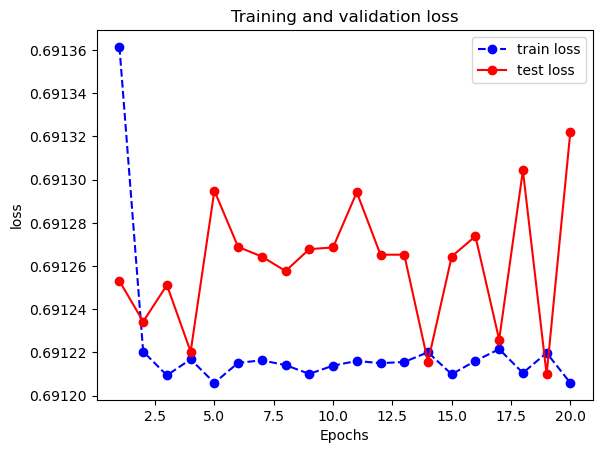

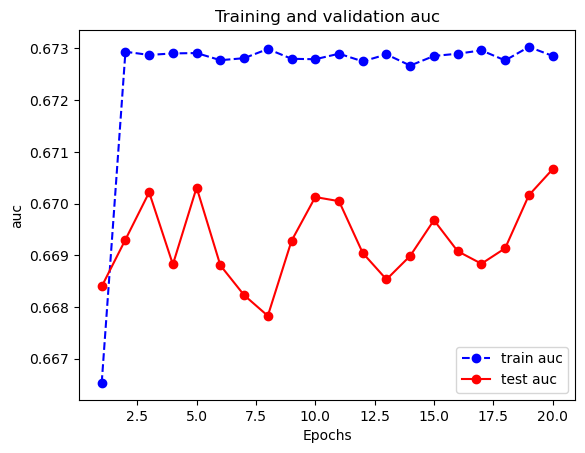

In [72]:
def plot_(attri):
    train=history[attri]
    test= history['test '+attri]
    epochs=range(1, len(train) + 1)
    plt.plot(epochs,train, 'bo--')
    plt.plot(epochs,test , 'ro-')
    plt.title('Training and validation '+attri)
    plt.xlabel("Epochs")
    plt.ylabel(attri)
    plt.legend(["train "+attri, 'test '+attri])
    plt.show()
plot_('loss')
plot_('auc')